### <center>Qu Capital - Onboarding Project by Thomas Rosal</center> <a name="top"></a>
---

### Contents
1. [Setup](#setup)
2. [Summary](#summary)
3. [Literature Review](#lit)
4. [Underlying Economics](#econ)
6. [Potential for Confounding Variables](#con)
7. [Data](#data)
8. [Exploring Correlations](#cor)
9. [Trading Strategy Thesis](#strat)
9. [Implementation - Naive Strategy](#naive)
11. [Implementation - Improved Strategy](#improved)
12. [Results from Out-of-Sample Backtests](#backtest)
13. [Bibliography](#bib)

---
### Setup <a name="setup"></a>
To execute this notebook requires the following, with relevant modules/libraries and data attached in the provided zip file:
1. Pyalgotrade implementation for Python 3
2. Modified Pyalgotrade libraries bar.py and plotter.py 
3. QuProject.py module, where the bulk of code (classes, functions, data munging) for this project resides
4. matplotlib, pandas, numpy Python modules
5. Data for AUD/USD, GBP/USD, EUR/USD, Big Mac Index 
6. (Optional) QuProject.R and the rmgarch library for R to implement DCC models
 
Instructions:
1. If you have not, install the libraries mentioned above
2. Unzip the attachment with this notebook in your current working directory, as the code relies on specifically defined file paths (especially the training and test data in the QuTrain and QuTest folders, respectively)
3. Replace the modified PyAlgoTrade modules (bar.py and plotter.py) in () with the modified versions provided
4. Execute the notebook!
 
Notes:
1. For techniques such as dynamic conditional correlation and some exploratory analysis, R was used (in part because a DCC implementation does not yet exist for Python); where relevant, the R code is also included.   

---
### Summary <a name="summary"></a>
The goal of this project is to explore the relationship between equity volatility and currency markets and exploiting this with a trading strategy. Specifically, we investigate the AUD/USD exchange rate and the VIX "fear gauge" equity volatility index. After a review of relevant literature, we present the underlying economic rationale behind price movements in the US dollar, the VIX, and potential correlations between the two. We then investigate correlations using various statistical methods, ranging from the typical Pearson's correlation to conditional correlation forecasts from DCC-GARCH models, which we introduce to modeling correlations between currency markets and equity volatility. Insights from these are incorporated into the given naive trading strategy, and we evaluate the performance of the improved strategy relative to the former. Discussions and further directions for future research are included in the results. 

---
### Literature Review <a name="lit"></a>
There is a host of academic literature around correlations between the prices of securities, given its immense relevance in asset pricing and portfolio construction. Most studies typically focus on cross sectional relationships between securities and temporal relationships between similar type securities (pairs of currencies, various stock indices, etc.), but none so far have directly investigated the relationship between exchange rates and equity volatility. However, there are several studies, the most relevant of which discussed below, whose methods and insights contribute to our line of inquiry. Generally, these studies deal with the relationship between equity indices and currencies, various models that account for heteroskedasticity in financial time series data, and other relevant econometric and statistical specifications. 

The earliest of the relevant studies [[1]](https://www.bis.org/publ/confp01l.pdf) investigates if implied volatilities from currency-based options inform exchange rate movements; specifically, the study considers risk reverals, derivatives whose payoff can turn positive or negative contingent on large deviations of currency spot rates to their forward rates, and hence are considered the market's best guess as to the directional bias of the currency. A stochastic volatility approach is used to show that changes in the prices of risk reverals capture the comovements or the directional bias of currency spot rates and their volatility.    

In an alternative approach, [[2]](https://arxiv.org/abs/1002.0321) considers the cross-correlations in the S&P500 and Dow Jones Euro Stoxx 50 through an eigvenvalue spectrum-RMT approach, investigating over sliding windows the spectrum of the correlation matrices of the constituent equities of both indices to see if there is some additional, uncaptured correlation structure in the random part of the eigenvalue spectrum (as defined in RMT). Among its results, the study shows that drawdowns on the indices were associated with periods when the largest eigenvalue was greatest and positive returns with periods when the largest eigenvalue was smallest.    

More recent literature, however, have been using multivariate GARCH approaches in modelling correlations between asset returns, motivated largely by the heteroskedasticity endemic in financial data. The earliest of which, [[3]](http://www.nber.org/papers/w5974), considers a very similar problem - assessing the accuracy of correlations implied volatilities from currency options in forecasting exchange rate movements - to [[1]](https://www.bis.org/publ/confp01l.pdf), but employs a GARCH approach while comparing its results to historical correlations and JP Morgan RiskMetrics' exponential weighted moving average correlation, finding that, as in the previous study, implied volatilities yield the best forecasts and, hence, contain relevant information with regards to their respective exchange rates. Several studies also use GARCH models to investigate the relationship between trading volumes and asset returns, typically finding that GARCH models succeed where conventional ones do not. In particular, [[4]](http://www.greta.it/wp/03.08.PDF) uses a GJR-GARCH model to uncover statistically significant relationships between the S&P100 and the Nikkei 225, while [[5]](https://www.sciencedirect.com/science/article/pii/S1044028312000026) finds causality (and its direction) between return volatility, trading volume, and stock returns in emerging Asian markets from analysis of a series of bivariate GARCH models. 

Building on the multivariate GARCH model, some studies have also examined the Dynamic Condtional Correlation model, a specific class of the GARCH models, and its use in the analysis and prediction of financial time series. Crucially, DCC models enable the tracing of the evolution of correlations (conditional correlations) between pairs of assets through time, hence the term "dynamic", while keeping estimated models parsimonious. Several studies have found varying degrees of success in its use. [[6]](https://www.sciencedirect.com/science/article/pii/S1049007807000590) uses DCC models to examine the dynamics between financial markets in Thailand and in Indonesia, finding that tight monetary policy by Thailand had little effect on Indonesia towards the end of 1998, and that the statistically significant correlations reveal some interdependence between both countries, which is, considerably lower in a crisis. [[7]](http://www.ccsenet.org/journal/index.php/ijef/article/view/5922) finds contrary results in an examination of the financial contagion following the 07-08 crisis; in examining the stock indices from 5 developed and 10 emerging countries, the study shows that the correlations between these countries considerably increased following the start of the financial crisis. Indeed, using the conditional correlations, the study is able to divide the countries into 3 groups of varying exposure to the US during the crisis. Other studies that use DCC models include [[8]](https://www.tandfonline.com/doi/abs/10.1080/13504850500447331),[[9]](https://www.tandfonline.com/doi/abs/10.1080/17446540500428843),[[10]](https://www.sciencedirect.com/science/article/pii/S030142151500004X). 

There is also a subset of literature that deals specifically with cointegrated financial time series, typically asset returns on some pair or group of assets with mean-reverting behavior relative to each other. This research is aimed particularly at exploting this behavior through pairs trading, a form of arbitrage, popularly employed in forex trading of pairs of currencies. [[11]](https://www1.unisg.ch/www/edis.nsf/SysLkpByIdentifier/4600/$FILE/dis4600.pdf) delivers an exposition around the subject, providing examples for how this is employed. 

Building on this literature, our investigation of the correlations between equity volatility and exchange rates incoporate the insights from these studies, particularly those of heteroskedasticity in dealing with time series data. From this, we explore correlations in the usual way. We also check if our series are cointegrated to see if pair trading strategies are feasible. Then further building on the use of multivariate GARCH models in the literature, we use a Dynamic Conditional Correlation model to examine the US dollar (AUD/USD exchange rate) and equity volatility (VIX), recovering conditional correlations through time in the process. The goal is to incorporate these insights and analytics to improve upon the results of a naive USD-long bias trading strategy.   

[Return to top](#top)

---
### Underlying Economics <a name="econ"></a>
In this project, we consider two assets: the US Dollar, defined in relation to the Australian Dollar, and the VIX, the plots of which from July 2012 to July 2016 are shown; log returns are underneath. 

<img src="img/USD-VIX.png">

#### US Dollar
The value of a currency relative to others is fundamentally a reflection of supply and demand of that currency; generally, if investors or the market prefer one currency over another, then the price of the former rises relative to latter. Several factors are known to affect the demand and supply of currencies, thereby impacting their exchange rates on either a short and/or long term horizon. These include the following, with a brief description of the dynamics:

- **Trade balance of underwriting government**: countries with large deficits imply that forex earnings are less than forex expenditures; demand for foreign currencies increase, thereby increasing the exchange rate, depreciating the currency of the high-defecit country.
- **Interest rate levels**: when a country has a higher domestic interest rate that foreign rates, capital inflow will occur (b/c higher return for investors) and increase demand for the domestic currency, thereby causing it to appreciate. 
- **Inflation**: when the inflation of a country rises, its currency's purchasing power declines, so the domestic currency depreciates relative to foreign currencies with relatively lower inflation.
- **Government intervention (fiscal and monetary policy)**: in addition to setting interest rates, governments through monetary policy, such as open market interventions, or even through massive expenditures, impact domestic currency valuations; for example, expansionary monetary and fiscal policy will tend to cause expediture deficits, which in turn devalue the domestic currency; anohter example is direct purchases of foreign currencies in large quantities, which many governments maintain; the exchange of such large quantities directly impact supply and demand, and hence, exchange rates.  
- **Economic strength**: strong/relatively more valuable domestic currencies **can** potentially be a sign of a country's economic strength, but this has to be considered with the other mentioned variables; overvalued exchange rates, as in the case of Greece in their recent quagmire, can cause lower economic growth.  
- **Safety**: in turbulent markets, some currencies of countries known for stability tend to appreciate, as thdid the Swiss Franc in 2012 relative to the rest of Euro currencies. 

In our investigation, we consider primarily the exchange rate between the Australian Dollar and the US Dollar. 

#### VIX Index
The CBOE Volatility Index (VIX), popularly known as the "fear gauge" is a measure of the market's 30-day expectation of volatility in the S&P500. Quoted in percentage points, the VIX Index, an implied volatility, is a weighted average of various put and call options on the S&P500 Index. Higher VIX Index values correspond to riskier market expectations. 

As a common measure of market volatility, the VIX is typically compared to the S&P500 in literature. The CBOE asserts, on its [website](http://www.cboe.com/products/vix-index-volatility/vix-options-and-futures/vix-index/the-relationship-of-the-spx-and-the-vix-index) and in a white paper [[12]](https://www.cboe.com/micro/vix/vixwhite.pdf), the VIX's inverse relationship with the S&P500, but opinions diverge in academia. In particular, [[13]](https://onlinelibrary.wiley.com/doi/pdf/10.1002/fut.20532) studies the information content in VIX options, which enabling trading the VIX Index (which itself is not technically tradable) in comparison to S&P500 options, as they theoretically ought to contain the same information; unfortunately, it finds that the information content of the volatilities implied by these two classes of options diverge, although improvements on forecasts of S&P500 direction can be improved incorporating implied volatilities from both S&P500 and VIX options.  

[Return to top](#top)

---
### Potential for Confounding Variables <a name="con"></a>
Given the earlier discussion on the factors that affect the valuation of a currency, it is entirely possible that our trading strategy does not control for these unknowns. As a motivating example, consider the low interest rate regime in the US following the financial crisis; such has depressed dollar valuations globally, but this is not necessarily a factor that is captured by variations in the VIX Index or the relative under/over valuation of the dollar. As another example, consider the most recent Davos conference earlier this year, when Secretary of the Treasury Steve Mnuchin's [assertion](https://www.cnbc.com/2018/01/24/dollar-tanks-the-most-in-10-months-after-mnuchin-says-weak-dollar-is-good.html) that "Obviously a weaker dollar is good for us as it relates to trade and opportunities" caused the US Dollar to plummet to a nearly 1-year low.  It can be argued that potentially confounding variables and other events such as those mentioned may impact any correlations or other relationships in our statistical analyses, models, and ultimately, our trading strategies. 

---
### Data <a name="data"></a>
As mentioned already mentioned earlier, we use the AUD/USD spot rate, from the Reserve Bank of Australia, as a proxy for the US dollar, and the VIX Index, from the CBOE, as a proxy for equity volatility in the US market. We use 6 years' worth of daily data, amounting to prices for 1,469 days, from June 29, 2012 to June 29, 2018.  

In addition to these pre-specified data, we also use **GBR/USD** and **EUR/USD** daily spot rates from the Bank of England and the St. Louis Federal Reserve, respectively, since popular opinion among analysts suggests that these currency pairs tend to move together. These are also used to later backtest our improved trading strategy. Notably, the data from the St. Louis Fed feature NA values for some dates. In this case, we linearly interpolate between them.  

For training and testing purposes, we divide our data into two three year periods: June 29, 2012 to June 30, 2015 (735 data points), and then from July 1, 2015 to June 29, 2018 (734 data points). These are our training and testing sets, respectively. Backtests and validation are conducted on the test set. Furthermore, the training and test sets are also further divided into 46 rolling windows each (a total of 92) 486 day (approx. 2 years), from which summary statistics of relevant strategy performance metrics are collected and reported.    
 
[Return to top](#top)

---
### Exploring Correlations <a name="cor"></a> 

We would like to see if there is a (potentiall statistically) significant enough relationship between the VIX and USD exchange rates. The aim of this exercise is to see if we can incorporate some statistical measure of correlation, if it exists, in a trading strategy.  

To avoid spurious correlations computed from price levels, we compute the correlations for the first differenced and the log returns for USD and VIX series. Below are scatterplots of both:

<img src="img/Scatter-2.png">

By inspection there seems to be no correlation; Pearson's correlation coefficient for the first differenced and log return pairs are -0.0329 and -0.0358, respectively. This result is hardly surprising, as daily financial data is known to be extremely noisy. Instead, it may be possible to find meaningful correlations by expanding our time horizin and considering weekly and weekly data. The scatterplots for weekly and monthly first differenced series and log returns are below: 

<img src="img/weekmonth.png">

While the weekly and monthly scatterplots look just as discouraging, we find improvements their correlations:

|                   | Weekly  |Monthly |
| --- |:---:|:----:|
| First Differenced | -0.0827 | 0.1206 |
| Log Returns       | -0.0743 | 0.0877 |

These weekly and monthly correlations, while small, suggest the existence, at least, of some relationship between the pair. This suggests that one improvement over the naive strategy can involve incorporating a rolling mean for the VIX with a 1-week to 1-month (as opposed to a historical, static mean over the entire period) can lead to better trading signals. 

However, a drawback of the correlations computed above is that they are static throughout the window. Many studies in the literature, as well as empirical verifications, have shown that financial time series data tend to express 'volatility clustering' in that times of volatility tend to happen together. As an example, [[14]](https://www.cfapubs.org/doi/pdf/10.2469/cp.v26.n1.9) shows that the returns on US and foreign equities have a correlation of -17% when both markets' returns are one standard deviation above their means, but display a correlation of +76% when both markets' returns are one standard deviation below the mean. Hence, if we are to incorporate correlations into our trading strategy, we must aim to compute some correlation that incorporates the temporal component of our time series data. 

First, we look at the cross-correlation between both series. Before we do this, we perform checks for stationarity as a prerequisite for the CCF. The following are the p-values from ADF and KPSS tests for stationarity on the daily log returns and first differences:

|                   | ADF  |KPSS |
| --- |:---:|:----:|
| First Differenced | 0.01 | 0.1 |
| Log Returns       | 0.01 | 0.1 |

The < 0.05 p-value for the ADF and the > 0.05 p-value of the KPSS test convince us that the pairs of transformed series are, indeed, stationary. Examination of their ACFs, shown below for the log returns (since first differenced series is nearly identical), further confirm this, as the lags die out quickly: 

<img src="img/ACFs.png">

Now, we check their CCF: 

<img src="img/CCF.png">

Notice that we have significant positive correlations at lags -10, 3, and 6, and significant negative correlations at lag 14 and 18. These suggest that the VIX at time $t$ is positively correlated with AUD/USD spot rates for times $t-10$, $t+3$, and $t+6$, while it is negatively correlated with the AUD/USD for times $t+14$ and $t+18$. (Is there an economic interpretation here? Unclear.)

Now, we note that from here onwards, we will be using the pair of log return series as opposed to the first differenced pair, due largely in part to the nice interpretation of log returns (i.e. additive, so can compound growth). 

While the CCF did not necessarily lead to any meaningful economic interpretation, we can now look towards estimating a Dynamic Conditional Correlation model to the log returns of the AUD/USD and the VIX to generate conditional correlations through time for investigation. Unfortunately, Python does not have an implementation for DCC models, but R, through the library ```rmgarch```, we fit a DCC-GARCH model to the daily log returns of our data. 
We plot the conditional correlations from the DCC fit, with +1/-1 as the red dashed lines, and below it, the AUD/USD spot rate:

<img src="img/dccfit.png">

Initial inspections of these correlations in relation to the AUD/USD spot rate reveal potential sell signals at the two highest peaks in the first plot, around April-May 2013 and in October 2013; notably, these also corresponded to declines in the S&P500 Index during that year. However, downward movements in the conditional correlations seem inconclusive. All together, these seem to suggest high correlations during drawdown periods, while inconclusive for drawups. Also, note that the mean of the time varying correlations correspond to the correlations of the daily log returns of the AUD/USD spot price and the VIX. We see here that following 3-SD deviations of the correlation from the mean, the value of the USD drops relative to the AUD, and hence may be a potential sell signal. 

Now that we have a DCC fit from our training data, we can iteratively incorporate forecasts of future correlation into our trading strategy! The technical specifics of this are dealt with below in the discussion of the improved strategy. In the backtesting section, we also explore how the correlation forecasts of our DCC fits compared with the test data as another means of seeing if there are meaningful trading signals generated by an application of this model.   

How does our model fit do? Below are plots of the realized and forecasted correlations as measured by our model. 

<img src="img/RandEstDCCfit.png">
    
Notice that our estimates actually overshoot the realized correlations, owing in part to the forecasts' larger standard deviation, but they still nicely follow the general direction of the realized correlations; this is obvious by visual inspection. For example, the forecasts correctly follow the four sharp peaks and two smaller peaks towards July 2018, as well as, to a lesser degree, four troughs throughout the forecast period. Unfortunately, the mean of the forecasts negatively overshoots the realized correlations. 

So, if we use the forecasts of our iteratively fitted models, we account for the overshooting in the strategy by increasing the SD threshold for buy and/or sell signals. Placed here is the R code to fit the DCC model and generate the correlation series shown in the first DCC fit plot. A clear (the best I could find) exposition on the math behind the DCC can be found [here](https://daim.idi.ntnu.no/masteroppgaver/004/4642/masteroppgave.pdf). 
```r
## DCC Fit
require(rmgarch)

garch11.spec = ugarchspec(
  mean.model=list(armaOrder=c(0,0)),
  variance.model=list(garchOrder=c(1,1), model="sGARCH"),
  distribution.model="norm"
)

# Specify a DCC-GARCH model
dcc.garch11.spec <- dccspec(
  uspec = multispec( replicate(2, garch11.spec)), 
  dccOrder = c(1,1), 
  distribution = "mvt" # We model residuals with a t-distribution, given its greater kurtosis, since
                       # our returns exhibited extreme values
)

# Fit the DCC using a two-step method outlined here:
#   https://daim.idi.ntnu.no/masteroppgaver/004/4642/masteroppgave.pdf
# Note that variable 'all.ts' is an xts object with the log returns of the AUD/USD spot and the VIX 
dcc.fit <- dccfit(
  dcc.garch11.spec,
  data=all.ts,
  fit.control=list(scale=TRUE)
)

# Munge the correlations for plotting and compute mean and standard deviation of correlations 
r1 <- rcor(dcc.fit, type="R")
mr1z <- mean(window(r1.z, start="2012-07-01", end="2014-07-01"))
sr1z <- sd(window(r1.z, start="2012-07-01", end="2014-07-01"))
r1.z <- zoo(r1[1,2,], order.by=time(all.ts))

# Plot the dynamic correlations 
plot(window(r1.z, start="2012-07-01", end="2014-07-01"),  
     ylab="Conditional Correlation", sub=paste("mean:", round(mr1z,3),"sd:", round(sr1z,3)),
     xlab="Date",
     xaxt="n",
     main="Time Varying Correlation of AUD/USD and VIX Index Log Returns")
axis.Date(1, at=seq(as.Date("2012-07-01", "%Y-%m-%d"), 
                    as.Date("2014-07-01", "%Y-%m-%d"), 
                    by="2 mon"), format="%b-%Y", cex.axis=0.8)
abline(h=mr1z, lty=2, lwd=1, col="blue")
abline(h=(mr1z+sr1z), lty=2, lwd=1, col="red")
abline(h=(mr1z-sr1z), lty=2, lwd=1, col="red")
```

[Return to top](#top)

---
###  Potential Strategy Thesis <a name="thesis"></a>
In line with the exposition above, it is clear that while there is no immediate and direct link between the equity volatility implied by the VIX and the valuation of exchange rates, particularly the US dollar, we can take advantage of some of the implications of the VIX in informing a long USD biased trading strategy. We outline the logic of a potential trading strategy, as well as simplifying assumptions, that will recover trading signals from that the VIX contains information on 30-day market expectations of volatility.   

First, we consider the valuation of the USD relative to other currencies as a measure of its strength. In times of market turmoil in which the VIX rapidly increases, dollar valuations should fall as investors look to other safer alternatives. This is seen most prominently during the 07-08 financial crisis, in the figure below,  when sharp increases in the VIX Index was immediately followed by severe depreciation in the USD exchange rate. 

<img src="img/FinCri.png">

From this, we aim to build analytics around the VIX into our strategy. Particularly, with the VIX is a measure of 30-day market expectations, we aim to use moving averages that assign more weight to more recent dates (like exponential as opposed to simple). 

Second, we consider the impact of the Australian Dollar's own valuation, potentially reflective of Australia's economy, relative to the US dollar. Inherent in the AUD/USD exchange rate is not only information on the US Dollar, but on its Australian counterpart as well; that the Australian Dollar can be over or undervalued relative to the US Dollar is captured in the exchange rate. We aim to control this away through using the Big Mac Index, a measure developed by the Economist that quantifies the relative over or undervaluation of a currency through the price of a Big Mac in that country. A positive Big Mac Index suggests overvaluation, and undervalued if negative. If the Australian Dollar is undervalued relative to the USD, then purchasing USD at a discount may generate stronger returns. 

Third, we consider the 'volatility clustering' phenomenon in our trading strategy, and attempt to control these away through the use of conditional correlations implied from a Dynamic Conditional Correlation model (an extension of multivate GARCH models, discussed briefly in the literature review). We use the fit of a DCC to our time series data to generate n-ahead forecasts of correlations based on our training data. Because of the forecasts required, we only test this addition to the naive strategy in the test set. More specifically, we start with the DCC fit in from our training data (realized returns from time $0$ to $t$) to forecast correlation for time $t+1$, and then we use a for loop to fit the DCC again for now realized data from time $0$ to $t+1$ to yield forecasts for time $t+2$, and so forth. For our testing out of sample, this estimates 733 DCC models, each of which iteratively yields a forecast for correlation at time $t+1$. Computation time for one vector of correlations is roughly 2.51 hours. 

Hence, from this, the trading strategy we arrive at is the following: 

```
Go long USD  if (AUD/USD Spot < AUD/USD EMA(15)) 
                and (VIX Index > EMA(VIX) - 1*SD(VIX))
                and (sign(Big Mac Index) = sign(-1)) 
Go short USD if (AUD/USD Spot > AUD/USD EMA(15)  
                and (VIX Index < EMA(VIX) + 1*SD(VIX))
                and (Correlation > EMA(Correlation) + 3*SD)
Hold no position otherwise.
```

We hope to measure the performance of this improved strategy over a given naive strategy, detailed below. 

[Return to top](#top)

---
### Trading Strategy Implementation - Naive Strategy <a name="naive"></a>
We now implement the given naive trading strategy: go long USD when the VIX is 2 standard deviations below its mean, go short when the VIX is 2 standard deviations above the mean, and hold no position otherwise. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plot

from pyalgotrade import strategy, plotter
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma, stats, cross
from pyalgotrade.stratanalyzer import sharpe, drawdown, returns

from QuProj import naiveStrat, getMetrics, rollingBacktest

naive = naiveStrat(15, "VixTrainDat.csv", "UsdTrainDat.csv")
metrics = getMetrics(naive)
print("Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%" 
        % (metrics[0], metrics[1], metrics[2], metrics[3]) )

Final Value: $9994.50 // Cumulative Return: -0.05% // Sharpe: -1.47  // Max Drawdown: 1.44%


The strategy posts a negative return; the negative Sharpe ratio, although to be taken with caution, is similarly discouraging. Before seeing if we can do better, we also consider its performance across narrower, rolling 2-year windows in our training set. As mentioned earlier, we run the strategy in 46 486-day long windows, from which we derive summary statistics around the strategy's performance analytics.  

In [2]:
rollingBacktest(naiveStrat,"Train","Aud")

Final Value (Avg): $10058.02 // Cumulative Return (Avg): 0.58% // Sharpe (Avg): -1.12  // Max Drawdown (Avg): 0.93%


While positive, the return is still meager. Where did this strategy go wrong? We also consider the plots for total cumulative returns and buy/sell signals to see how well we did: 

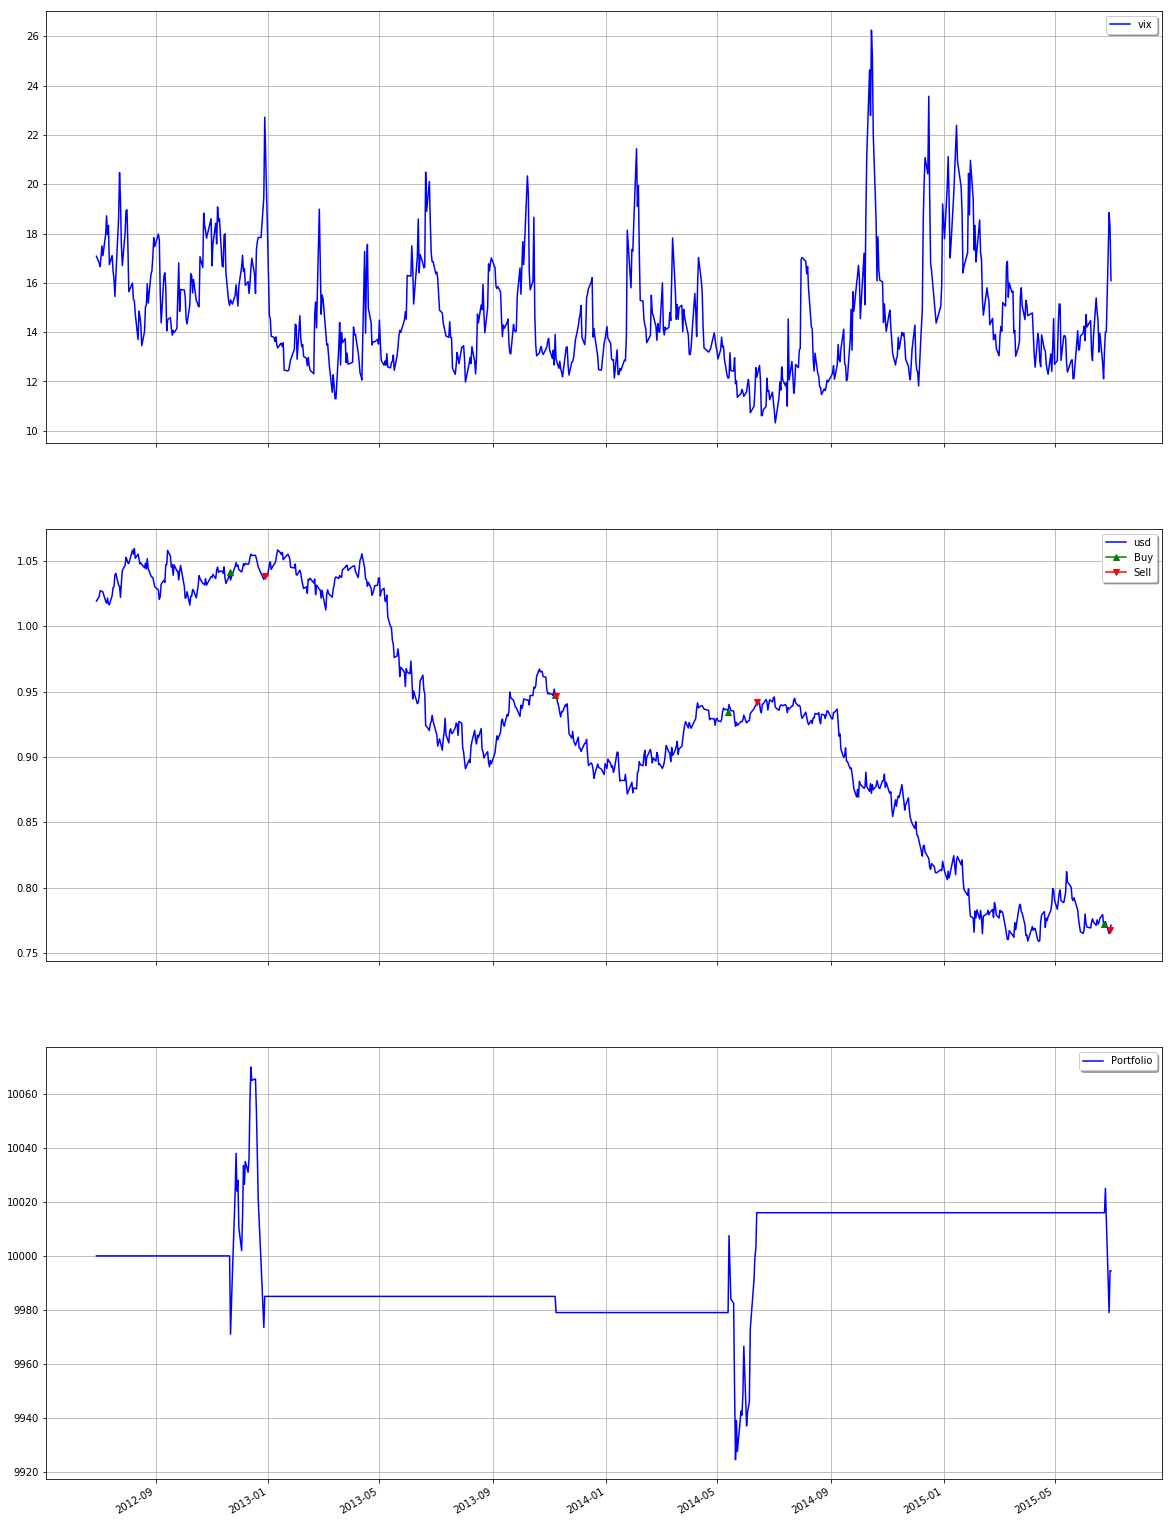

In [3]:
naive = naiveStrat(15, "VixTrainDat.csv", "UsdTrainDat.csv")
plt = plotter.StrategyPlotter(naive, plotBuySell=True)
naive.run()
plt.plot()

The biggest takeaway from these graphs can be found in the middle, plotting the AUD/USD spot price with buy and sell signals of our strategy layered on top. Notice that we see the effect of volatility clustering: buy and sell signals are extremely close to one another, which suggest marked deviations from the VIX's rolling average. Controlling for this volatility clustering may yield a better strategy.   

[Return to top](#top)

---
### Trading Strategy Implementation - Improved Strategy <a name="improved"></a>

To implement our improvement, we tested the inclusion and exclusion of various additions we proposed, and found that the strategy that performed best relative to others and our naive strategy uses exponentially weighted moving averages for the VIX, but not the forecasted correlation data and the Big Mac Index. Incorporating any of the latter two result in significantly fewer and arbitrary buy and sell signals, and usually exhibited much more variable cumulative returns. The hope was that periods of increased or rapidly increasing correlation would signify a decline in USD value, yielding a signal to sell when this occurs. However, we note that the correlations forecasted by our model are, as with the realized data, have their means tightly centered around -0.03, already small to begin with. Other studies like those mentioned that explore these dynamic correlations typically do so with pairs of similar assets (such as two indices, or a set of commodities) to find significant corrleations north of 50%. The code for the original strategy that included forecasted correlations is still included in the Python module, and can be tested with pyalgotrade.  

So, we implement a simpler, modified version of the earlier proposed strategy. 

```
Go long USD  if (AUD/USD Spot < AUD/USD SMA(15)) 
                and (VIX Index > EMA(VIX) - 1*SD(VIX))
Go short USD if (VIX Index > EMA(VIX) - 1*SD(VIX))
Hold no position otherwise.
```

Hence, we present results for that here: 

In [4]:
from QuProj import improvedStrat1

improved1 = improvedStrat1(15, "VixTrainDat.csv", "UsdTrainDat.csv")
metrics = getMetrics(improved1)

print("Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%" 
        % (metrics[0], metrics[1], metrics[2], metrics[3]) )

Final Value: $10128.00 // Cumulative Return: 1.28% // Sharpe: -0.47  // Max Drawdown: 1.40%


The improved strategy makes a marginal, but hardly significant improvement. The reduction in the Sharpe ratio, though, is encouraging. Running our strategy on rolling windows, we find: 

In [5]:
rollingBacktest(improvedStrat1,"Train","Aud")

Final Value (Avg): $10064.22 // Cumulative Return (Avg): 0.64% // Sharpe (Avg): -0.80  // Max Drawdown (Avg): 1.07%


Again, we see marginal, but hardly significant improvements on this strategy across all metrics. Now, we explore the performance of both strategies on out of sample data. The plots below suggest that this strategy might do potentially well with sell signals, since they occur around peaks. 

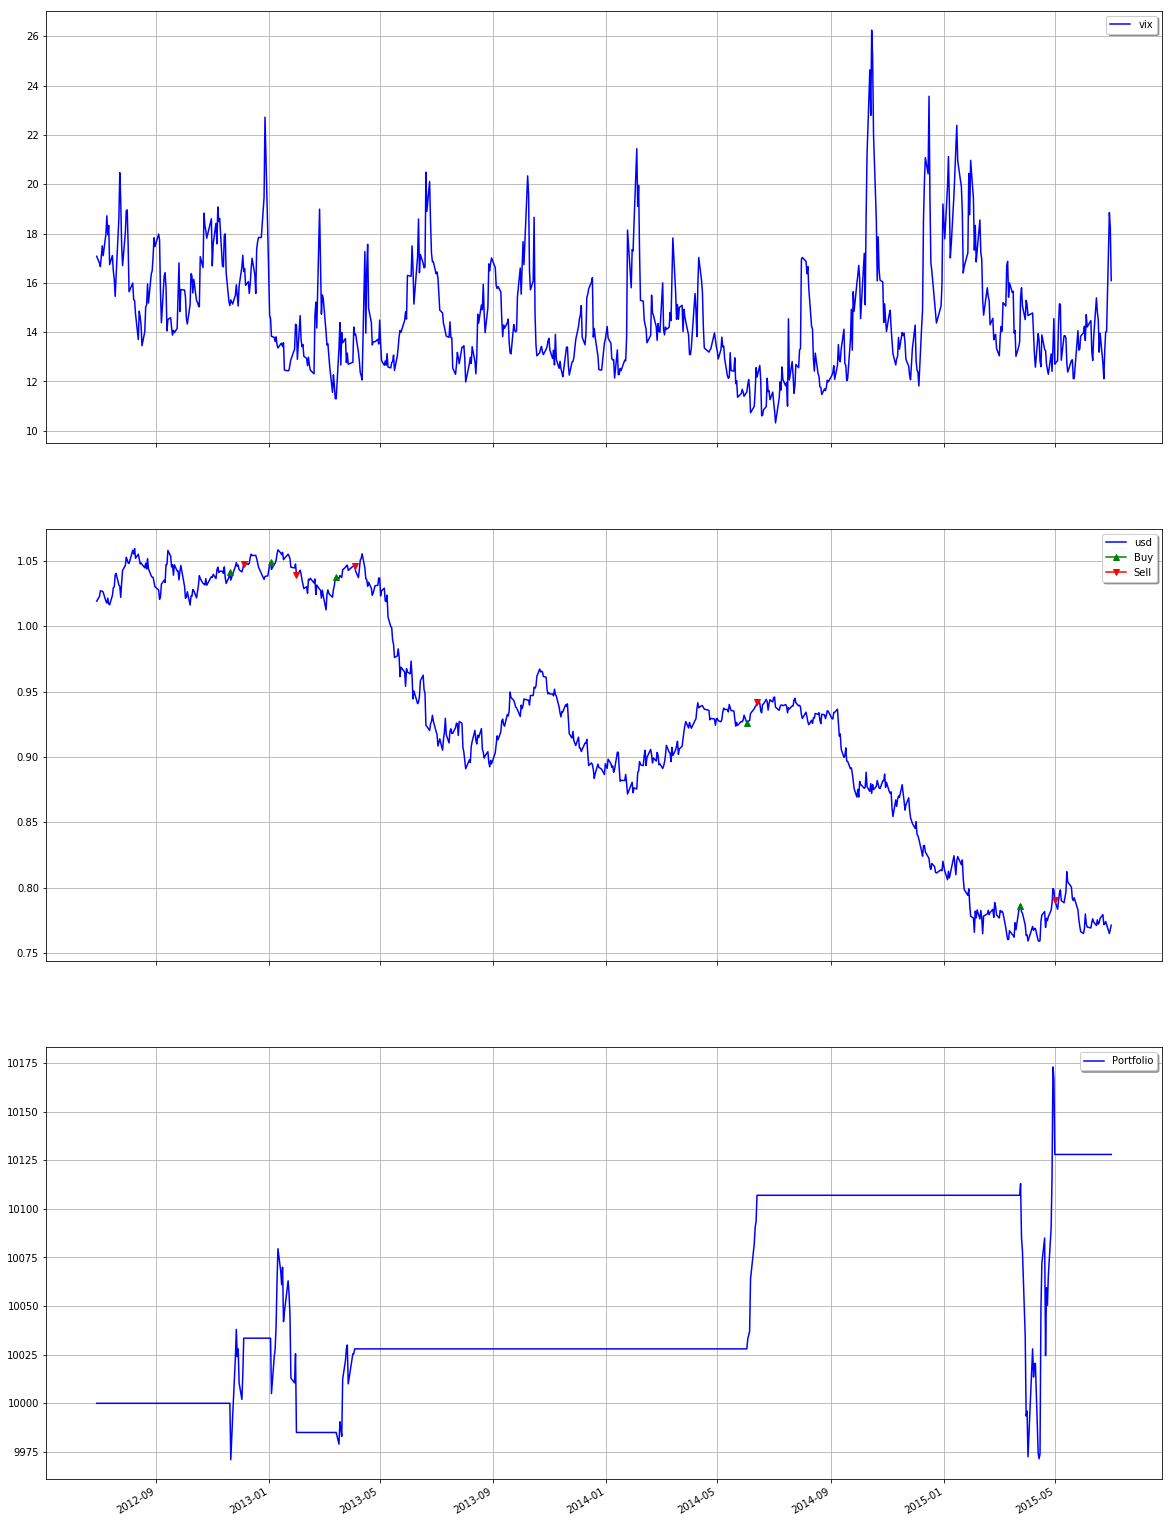

In [6]:
improved = improvedStrat1(15, "VixTrainDat.csv", "UsdTrainDat.csv")
plt = plotter.StrategyPlotter(improved, plotBuySell=True)
improved.run()
plt.plot()

[Return to top](#top)

---
### Results from Backtests <a name="backtest"></a>

As mentioned earlier, we conduct out of sample backtests on data from July 1, 2015 to June 29, 2018 (734 data points). We test over the entire period, approx. 3 years, and over 46 rolling windows of approx. 2 year periods. Performance analytics and summary statistics are reported below:

#### Naive vs. Improvement Strategy Out of Sample Backtests

In [7]:
print("Naive Strategy Out of Sample Test Results:")
naive = naiveStrat(15, "VixTestDat.csv", "UsdTestDat.csv")
metrics = getMetrics(naive)
print("Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%" 
        % (metrics[0], metrics[1], metrics[2], metrics[3]) )
rollingBacktest(naiveStrat,"Test","Aud")

print("\n"+"Improved Strategy Out of Sample Test Results:")
improved1 = improvedStrat1(15, "VixTestDat.csv", "UsdTestDat.csv")
metrics = getMetrics(improved1)
print("Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%" 
        % (metrics[0], metrics[1], metrics[2], metrics[3]) )
rollingBacktest(improvedStrat1,"Test","Aud")

Naive Strategy Out of Sample Test Results:
Final Value: $10107.00 // Cumulative Return: 1.07% // Sharpe: -0.42  // Max Drawdown: 2.12%
Final Value (Avg): $10163.17 // Cumulative Return (Avg): 1.63% // Sharpe (Avg): -0.34  // Max Drawdown (Avg): 0.88%

Improved Strategy Out of Sample Test Results:
Final Value: $9745.00 // Cumulative Return: -2.55% // Sharpe: -1.74  // Max Drawdown: 3.65%
Final Value (Avg): $9927.15 // Cumulative Return (Avg): -0.73% // Sharpe (Avg): -1.77  // Max Drawdown (Avg): 1.41%


Over the entire out of sample period, the improved strategy underperforms the naive strategy; to its detriment the improved strategy exhibits a lower average final equity, lower average cumulative, lower Sharpe, and higher drawdown. We attempt to verify this result further with alternative out of sample backtests with the GBP/USD and the EUR/USD.  

#### Naive vs. Improved Strategy for GBP/USD and EUR/USD 

In [8]:
print("GBP/USD Naive Strategy Out of Sample Test Results:")
naive = naiveStrat(15, "VixTestDat.csv", "GbpTestDat.csv")
metrics = getMetrics(naive)
print("Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%" 
        % (metrics[0], metrics[1], metrics[2], metrics[3]) )
rollingBacktest(naiveStrat,"Test","Gbp")

print("\n"+"GBP/USD Improved Strategy Out of Sample Test Results:")
improved1 = improvedStrat1(15, "VixTestDat.csv", "GbpTestDat.csv")
metrics = getMetrics(improved1)
print("Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%" 
        % (metrics[0], metrics[1], metrics[2], metrics[3]) )
rollingBacktest(improvedStrat1,"Test","Gbp")

print("\n"+"EUR/USD Naive Strategy Out of Sample Test Results:")
naive = naiveStrat(15, "VixTestDat.csv", "EurTestDat.csv")
metrics = getMetrics(naive)
print("Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%" 
        % (metrics[0], metrics[1], metrics[2], metrics[3]) )
rollingBacktest(naiveStrat,"Test","Eur")

print("\n"+"EUR/USD Improved Strategy Out of Sample Test Results:")
improved1 = improvedStrat1(15, "VixTestDat.csv", "EurTestDat.csv")
metrics = getMetrics(improved1)
print("Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%" 
        % (metrics[0], metrics[1], metrics[2], metrics[3]) )
rollingBacktest(improvedStrat1,"Test","Eur")


GBP/USD Naive Strategy Out of Sample Test Results:
Final Value: $9465.99 // Cumulative Return: -5.34% // Sharpe: -1.05  // Max Drawdown: 6.43%
Final Value (Avg): $9931.60 // Cumulative Return (Avg): -0.68% // Sharpe (Avg): -0.58  // Max Drawdown (Avg): 3.30%

GBP/USD Improved Strategy Out of Sample Test Results:
Final Value: $9641.33 // Cumulative Return: -3.59% // Sharpe: -1.14  // Max Drawdown: 5.41%
Final Value (Avg): $9705.11 // Cumulative Return (Avg): -2.95% // Sharpe (Avg): -1.06  // Max Drawdown (Avg): 4.48%

EUR/USD Naive Strategy Out of Sample Test Results:
Final Value: $9999.00 // Cumulative Return: -0.01% // Sharpe: -0.54  // Max Drawdown: 4.28%
Final Value (Avg): $10251.27 // Cumulative Return (Avg): 2.51% // Sharpe (Avg): -0.04  // Max Drawdown (Avg): 2.33%

EUR/USD Improved Strategy Out of Sample Test Results:
Final Value: $9550.50 // Cumulative Return: -4.49% // Sharpe: -1.27  // Max Drawdown: 5.92%
Final Value (Avg): $9966.87 // Cumulative Return (Avg): -0.33% // Sharp

Given that analyst consensus is that AUD/USD, GBP/USD, and EUR/USD tend to move together, we expect that our improved strategy would outperform the given naive strategy in our case. However, as evidenced by out of sample backtests for these currencies, there is no discernible pattern in the performance analytics of both strategies. A preliminary conclusion might be that our model isn't properly accounting for the currency movements we anticipated (we focus more on our strategies' ability to generate "correct" buy and sell signals based on the trading logic informed by our research).  

[Return to top](#top)

---
### Bibliography<a name="bib"></a>


[[1]](https://www.bis.org/publ/confp01l.pdf) Is there a premium for currencies correlated with volatility? Some evidence from risk reversals.  

[[2]](https://arxiv.org/abs/1002.0321) Cross-Correlation Dynamics in Financial Time Series
 
[[3]](http://www.nber.org/papers/w5974) The Forecasting Ability of Correlations Implied in Foreign Exchange Options
 
[[4]](http://www.greta.it/wp/03.08.PDF) Variance (Non-)Causality: A Bivariate GARCH-type Model
 
[[5]](https://www.sciencedirect.com/science/article/pii/S1044028312000026) The bivariate GARCH approach to investigating the relation between stock returns, trading volume, and return volatility
 
[[6]](https://www.sciencedirect.com/science/article/pii/S1049007807000590) Dynamic conditional correlation analysis of financial market interdependence: An application to Thailand and Indonesia
 
[[7]](http://www.ccsenet.org/journal/index.php/ijef/article/view/5922) A Dynamic Conditional Correlation Analysis of Financial Contagion: The Case of the Subprime Credit Crisis
 
[[8]](https://www.tandfonline.com/doi/abs/10.1080/13504850500447331) On the application of the dynamic conditional correlation model in estimating optimal time-varying hedge ratios
 
[[9]](https://www.tandfonline.com/doi/abs/10.1080/17446540500428843) Flexible Dynamic Conditional Correlation multivariate GARCH models for asset allocation
 
[[10]](https://www.sciencedirect.com/science/article/pii/S030142151500004X) Oil prices and financial stress: A volatility spillover analysis
 
[[11]](https://www1.unisg.ch/www/edis.nsf/SysLkpByIdentifier/4600/$FILE/dis4600.pdf) Cointegration Based Algorithmic Pairs Trading
 
[[12]](https://www.cboe.com/micro/vix/vixwhite.pdf) CBOE VIX Index White Paper
 
[[13]](https://onlinelibrary.wiley.com/doi/pdf/10.1002/fut.20532) The information content of the S&P 500 index and VIX options on the dynamics of the S&P 500 index
 
[[14]](https://www.cfapubs.org/doi/pdf/10.2469/cp.v26.n1.9)